# Financial Time Series Analysis
## Automotive Manufacturing Company Cash Flow Analysis

**Objective**: Forecast future cash flows and detect anomalies in historical financial data

### Summary of Workflow:
* **Exploratory Data Analysis (EDA):** Investigate trends, seasonality, and variability.
* **Data Preprocessing:** Handle missing values, scale data, and ensure stationarity.
* **Forecasting Models:** Compare ARIMA and Prophet models for forecasting accuracy.
* **Anomaly Detection:** Identify irregular data points using statistical methods.
* **Conclusion and Recommendations:** Summarize findings and suggest next steps.

## 0. Clone github repo and install all required libraries

In [1]:
!git clone https://github.com/AbhiRishi96/ABB_assessment.git

Cloning into 'ABB_assessment'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 25 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 9.31 KiB | 1.55 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [2]:
!pip install pandas numpy matplotlib seaborn statsmodels scikit-learn prophet

## 1. Importing all necessary libraries

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical and time series libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Modeling libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

# Forecasting libraries
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## 2. Data Loading and Exploratory Data Analysis (EDA)

In [20]:
# Load dataset
data = pd.read_csv(r'/content/ABB_assessment/csv/sample_financial_time_series.csv', parse_dates=['Date'])
# using parse_dates to convert specified columns to datetime objects
data.set_index('Date', inplace=True)

# Display basic information
print("Dataset Information:")
print(data.info())
print(data.head())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2014-01-01 to 2023-12-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Cash_Flow  120 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB
None
            Cash_Flow
Date                 
2014-01-01  52.483571
2014-02-01  51.821786
2014-03-01  58.217518
2014-04-01  64.967244
2014-05-01  58.418206


In [21]:
# Display Descriptive statistics
print("Descriptive Statistics:")
print(data.describe())

Descriptive Statistics:
        Cash_Flow
count  120.000000
mean   100.268329
std     30.504156
min     51.821786
25%     69.293975
50%     99.103707
75%    126.604978
max    167.521340


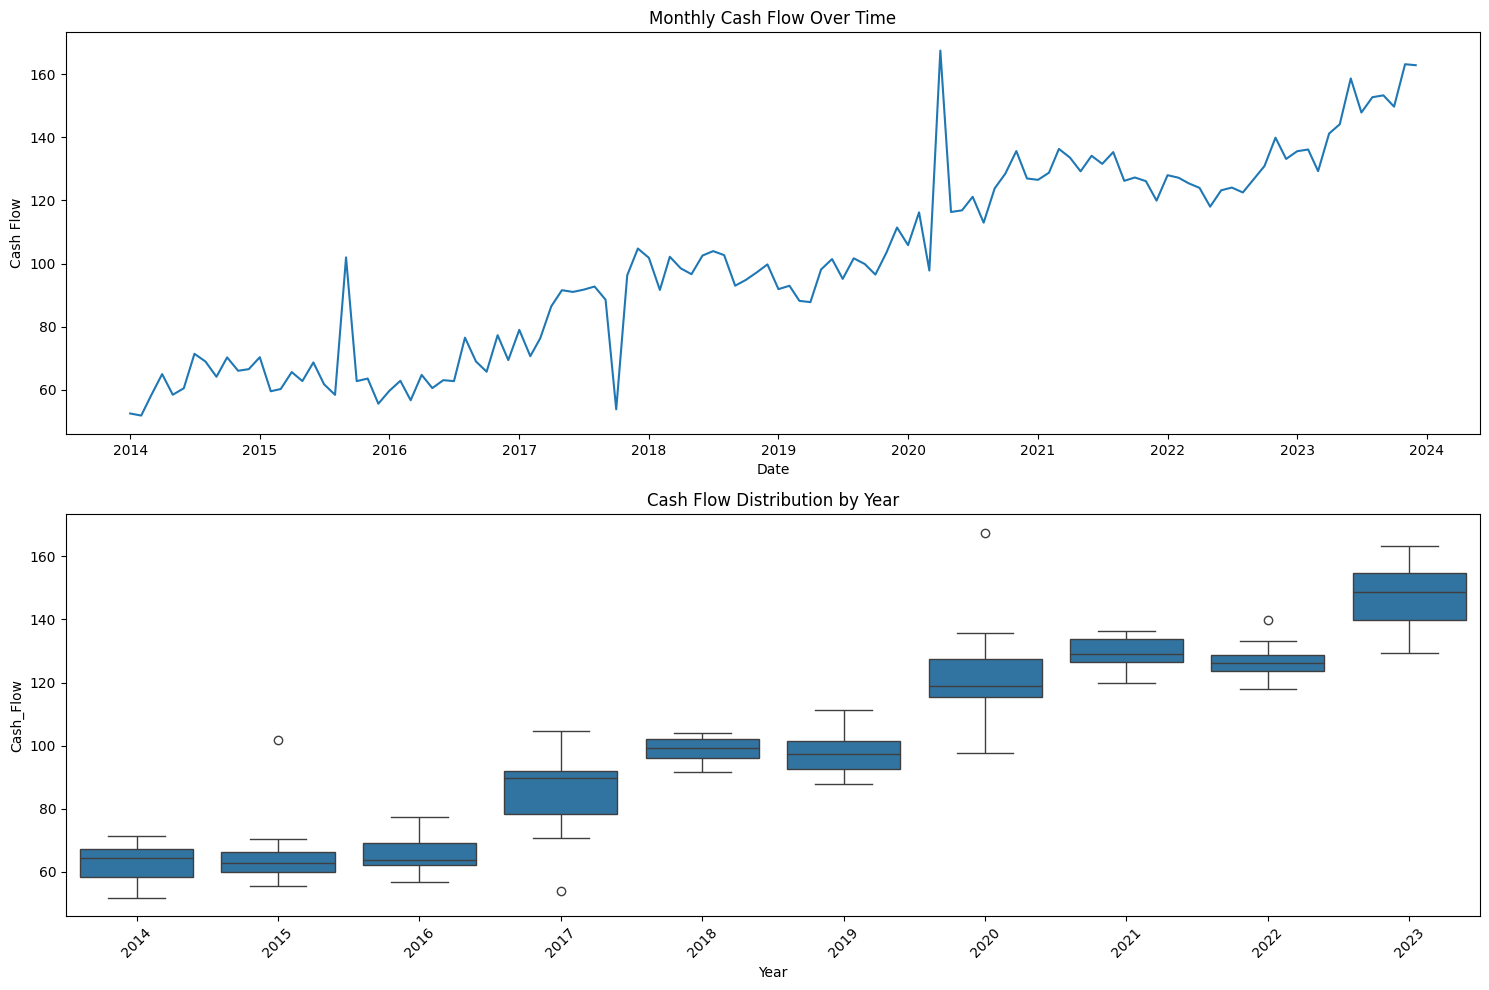

In [22]:
# Visualization of Time Series
plt.figure(figsize=(15, 10))

# Time Series Plot
plt.subplot(2, 1, 1)
plt.plot(data.index, data['Cash_Flow'])
plt.title('Monthly Cash Flow Over Time')
plt.xlabel('Date')
plt.ylabel('Cash Flow')

# Boxplot by Year
plt.subplot(2, 1, 2)
data['Year'] = data.index.year
sns.boxplot(x='Year', y='Cash_Flow', data=data)
plt.title('Cash Flow Distribution by Year')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 2. Stationarity Test

We'll use the Augmented Dickey-Fuller test to check if the time series is stationary.

The **Augmented Dickey-Fuller (ADF)** test is a statistical test used to determine whether a time series is stationary or contains a unit root. Stationarity is a critical concept in time series analysis, indicating that the statistical properties of the series (mean, variance, autocorrelation) remain constant over time.

In [25]:
# Augmented Dickey-Fuller Test
def adf_test(timeseries):
    print('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [28]:
# Perform ADF test
adf_test(data['Cash_Flow'])

Results of Augmented Dickey-Fuller Test:
Test Statistic                   0.060516
p-value                          0.963260
#Lags Used                       4.000000
Number of Observations Used    115.000000
Critical Value (1%)             -3.488535
Critical Value (5%)             -2.887020
Critical Value (10%)            -2.580360
dtype: float64


## 3. Data Preprocessing

In [38]:
# Check for missing values
print("Missing Values:")
print(data.isnull().sum())

# Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data['Cash_Flow_Scaled'] = scaler.fit_transform(data[['Cash_Flow']])

# Prepare data for forecasting
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

Missing Values:
Cash_Flow           0
Year                0
Cash_Flow_Diff      1
Cash_Flow_Scaled    0
anomaly_score       0
dtype: int64


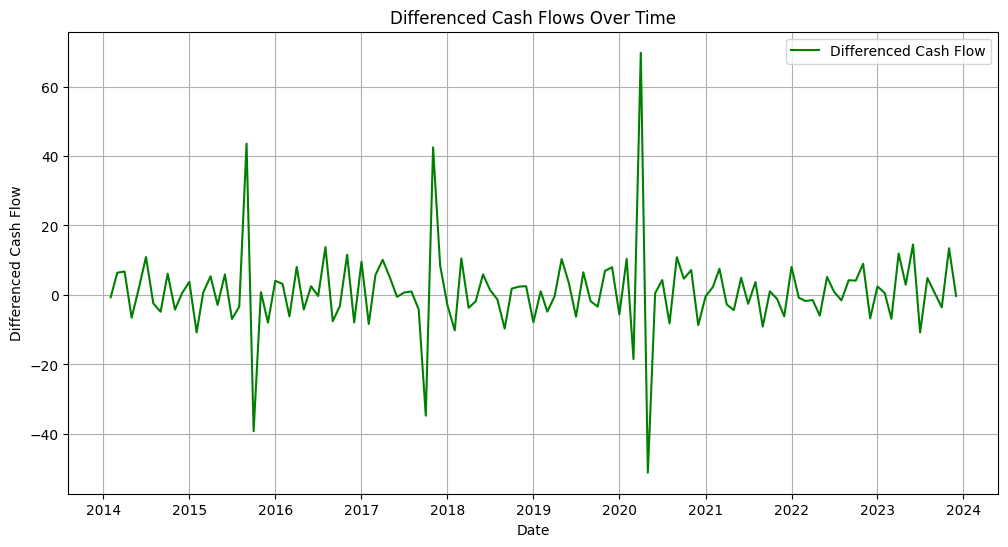

In [35]:
# Apply differencing to make data stationary
data_diff = data['Cash_Flow'].diff().dropna()

# Plot the differenced data
plt.figure(figsize=(12, 6))
plt.plot(data_diff.index, data_diff, label='Differenced Cash Flow', color='green')
plt.title('Differenced Cash Flows Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Cash Flow')
plt.legend()
plt.grid(True)
plt.show()

## 4: Forecasting Models

We'll compare two forecasting models:
1. ARIMA (Autoregressive Integrated Moving Average)
2. Prophet (Facebook's Time Series Forecasting Tool)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3gkpb_59/5b4rcqoy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3gkpb_59/m9zw9_dt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52984', 'data', 'file=/tmp/tmp3gkpb_59/5b4rcqoy.json', 'init=/tmp/tmp3gkpb_59/m9zw9_dt.json', 'output', 'file=/tmp/tmp3gkpb_59/prophet_modelp7t9waj8/prophet_model-20241214103708.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:37:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:37:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ARIMA Mean Absolute Error: 13.504917773117802
Prophet Mean Absolute Error: 15.031502791954901


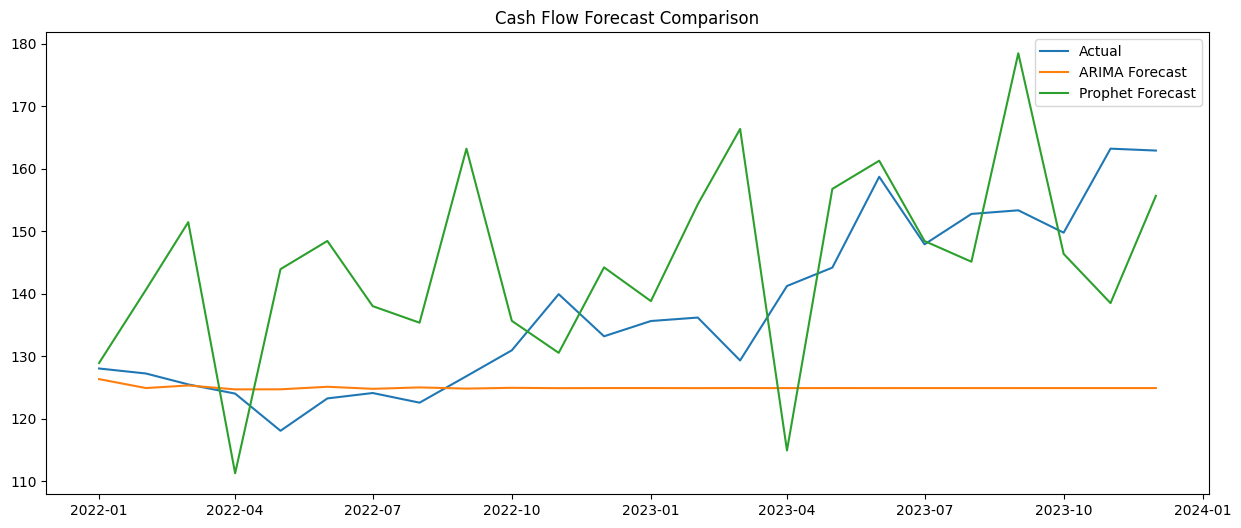

In [39]:
# Prepare data for Prophet
df_prophet = data.reset_index()[['Date', 'Cash_Flow']].rename(columns={'Date': 'ds', 'Cash_Flow': 'y'})

# ARIMA Model
arima_model = ARIMA(train['Cash_Flow'], order=(5,1,2))
arima_results = arima_model.fit()

# ARIMA Forecast
arima_forecast = arima_results.forecast(len(test))
arima_mae = mean_absolute_error(test['Cash_Flow'], arima_forecast)

# Prophet Model
prophet_model = Prophet()
prophet_model.fit(df_prophet[:train_size])

# Prophet Forecast
future = prophet_model.make_future_dataframe(periods=len(test), freq='M')
prophet_forecast = prophet_model.predict(future)
prophet_mae = mean_absolute_error(test['Cash_Flow'],
                                   prophet_forecast.tail(len(test))['yhat'])

# Model Comparison
print("ARIMA Mean Absolute Error:", arima_mae)
print("Prophet Mean Absolute Error:", prophet_mae)

# Visualization of Forecasts
plt.figure(figsize=(15, 6))
plt.plot(test.index, test['Cash_Flow'], label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.plot(test.index, prophet_forecast.tail(len(test))['yhat'], label='Prophet Forecast')
plt.title('Cash Flow Forecast Comparison')
plt.legend()
plt.show()

## 6. Anamoly Detection

The anomalies detected by the Isolation Forest in the code are points in the Cash Flow data that are flagged as unusual or significantly different from the majority of the data.

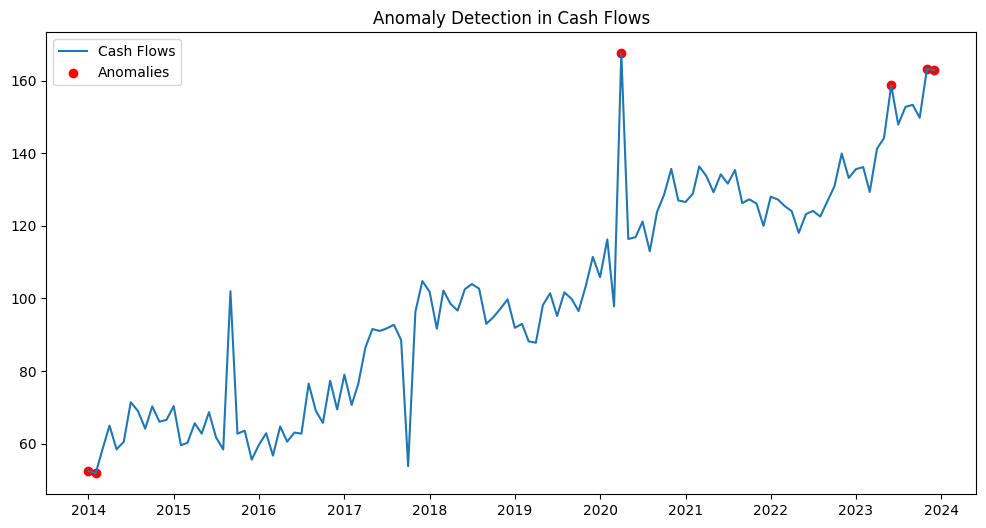

In [33]:
# Apply Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.05, random_state=42)
data['anomaly_score'] = iso_forest.fit_predict(data[['Cash_Flow']])

# Highlight anomalies
anomalies = data[data['anomaly_score'] == -1]

# Plot anomalies
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Cash_Flow'], label='Cash Flows')
plt.scatter(anomalies.index, anomalies['Cash_Flow'], color='red', label='Anomalies')
plt.legend()
plt.title('Anomaly Detection in Cash Flows')
plt.show()

## 7. Conclusion and Recommendations

### Key Findings:
1. **Data Characteristics**
   - The cash flow data shows variability over time
   - Potential seasonal patterns observed

2. **Forecasting**
   - ARIMA and Prophet models were compared
   - Model performance evaluated using Mean Absolute Error

3. **Anomalies**
   - Several anomalous data points detected using Z-score method

### Recommendations:
1. Further investigate the detected anomalies
2. Consider incorporating external economic indicators
3. Explore more advanced anomaly detection techniques
4. Periodically update and retrain the forecasting models